In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

from shapely.geometry import Point
from scipy.special import factorial
from torch.utils.data import DataLoader
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from data_helpers import get_data, get_split_indices, get_torch_dataset
from modules import FTTransformer, FeatureTokenizer, TransformerEncoder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the data

data = get_data("splot")
species_names = pd.read_csv("data/species_names.csv")

min_num_obs = 20
species_names = species_names[data["y"].sum(axis=0) > min_num_obs]
species_names["new_index"] = np.arange(len(species_names))
data["y"] = data["y"][:, data["y"].sum(axis=0) > min_num_obs]

i_lon = data["tabular_names"].index("Longitude")
i_lat = data["tabular_names"].index("Latitude")

data_indices = np.arange(len(data["tabular_x"]))
coordinates = data["tabular_x"][:, [i_lon, i_lat]]

train_indices, val_indices, test_indices = get_split_indices(data, mode="interpolate")

mode = "extrapolate"

n_features = data["tabular_x"].shape[1]
n_samples, n_species = data["y"].shape

data["x_train"], data["y_train"] = data["tabular_x"][train_indices], data["y"][train_indices]
data["x_val"], data["y_val"] = data["tabular_x"][val_indices], data["y"][val_indices]
data["x_test"], data["y_test"] = data["tabular_x"][test_indices], data["y"][test_indices]

train_mean = np.nanmean(data["x_train"], axis=0)
train_std = np.nanstd(data["x_train"], axis=0)
data["x_test"] = (data["x_test"] - train_mean)/(train_std + 0.0001)
data["x_val"] = (data["x_val"] - train_mean)/(train_std + 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

worldclim_data = np.load("data/europe_map_worldclim.npy")
soilgrid_data = np.load("data/europe_map_soilgrids.npy")
land_points_coordinates = np.load("data/europe_map_coordinates.npy")
topographic_data = np.load("data/europe_map_topography.npy")
all_metadata_data = np.empty((len(worldclim_data), 20))
all_metadata_data[:] = np.nan
human_data = np.load("data/europe_map_human.npy")

satclip_embeddings = np.load("data/europe_map_satclip_embeddings.npy").astype(np.float32)

train_mean = torch.tensor(np.nanmean(data["x_train"], axis=0)).to(device)
train_std = torch.tensor(np.nanstd(data["x_train"], axis=0)).to(device)

x = np.concatenate([worldclim_data, soilgrid_data, land_points_coordinates, topographic_data, all_metadata_data, human_data], axis=1).astype(np.float32)
x = torch.tensor(x).to(device)

x = (x - train_mean)/(train_std + 0.0001)
        
x_mask = torch.zeros(x.shape).to(device)

# Bounding box for the area of interest
xmin, xmax = -10, 31
ymin, ymax = 36, 56

In [4]:
tabular_names = np.array(data["tabular_names"])

wc_indices = list(range(19))
print("WorldClim:")
print(wc_indices)
print(tabular_names[wc_indices])

sg_indices = list(range(19, 27))
print("\nSoilGrids:")
print(sg_indices)
print(tabular_names[sg_indices])

loc_indices = list(range(27, 29))
print("\nLocation:")
print(loc_indices)
print(tabular_names[loc_indices])

topo_indices = list(range(29, 32))
print("\nTopography:")
print(topo_indices)
print(tabular_names[topo_indices])

meta_indices = list(range(32, 34))
print("\nMetadata:")
print(meta_indices)
print(tabular_names[meta_indices])

cover_indices = list(range(34, 45))
print("\nCover:")
print(cover_indices)
print(tabular_names[cover_indices])

height_indices = list(range(45, 52))
print("\nHeight:")
print(height_indices)
print(tabular_names[height_indices])

humans_indices = list(range(52, 61))
print("\nHumans influence:")
print(humans_indices)
print(tabular_names[humans_indices])

###

metaplus_indices = list(range(32, 52))
print("\nMetadata + Cover + Height:")
print(metaplus_indices)
print(tabular_names[metaplus_indices])

WorldClim:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
['bio_1' 'bio_2' 'bio_3' 'bio_4' 'bio_5' 'bio_6' 'bio_7' 'bio_8' 'bio_9'
 'bio_10' 'bio_11' 'bio_12' 'bio_13' 'bio_14' 'bio_15' 'bio_16' 'bio_17'
 'bio_18' 'bio_19']

SoilGrids:
[19, 20, 21, 22, 23, 24, 25, 26]
['ORCDRC' 'PHIHOX' 'CECSOL' 'BDTICM' 'CLYPPT' 'SLTPPT' 'SNDPPT' 'BLDFIE']

Location:
[27, 28]
['Longitude' 'Latitude']

Topography:
[29, 30, 31]
['Elevation' 'Slope' 'Aspect']

Metadata:
[32, 33]
['Location_uncertainty' 'Releve_area']

Cover:
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
['Cover_total' 'Cover_tree_layer' 'Cover_shrub_layer' 'Cover_herb_layer'
 'Cover_moss_layer' 'Cover_lichen_layer' 'Cover_algae_layer'
 'Cover_litter_layer' 'Cover_bare_rocks' 'Cover_cryptogams'
 'Cover_bare_soil']

Height:
[45, 46, 47, 48, 49, 50, 51]
['Height_trees_highest' 'Height_trees_lowest' 'Height_shrubs_highest'
 'Height_shrubs_lowest' 'Height_herbs_average' 'Height_herbs_lowest'
 'Height_herbs_highest']

Humans

In [11]:
# Define and load the model
d_hidden = 192
n_layers = 6
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)

model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()
print("Model loaded")

Model loaded


In [ ]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

species_names = ["anthyllis_vulneraria", "vaccinium_myrtillus", "quercus_ilex"]
species_indices = [896, 12268, 10030]

subsets = [wc_indices, sg_indices, topo_indices, loc_indices, humans_indices]
d = len(subsets)
num_combinations = 2**d
satclip = False
batch_size = 2000
factorials = factorial(range(d+1))

for species_name, species_idx in zip(species_names, species_indices):
    
    species_obs = data["y"][:, species_idx]
    print("species considered:", species_name)
    print("Number of presence data:", species_obs.sum())
    print("Number of absence data:", (~species_obs).sum())

    combinations = np.array([list(np.binary_repr(i, width=d)) for i in range(num_combinations)], dtype=int)
    all_predictions = []

    # Compute predictions for all combinations and locations
    for i_combination, combination in enumerate(combinations):
        print(f"Combination {i_combination + 1}/{num_combinations}")
        excluded_variables = [metaplus_indices]
        for i, s in enumerate(combination):
            if s == 0:
                excluded_variables.append(subsets[i])
        
        if excluded_variables:
            excluded_variables = np.concatenate(excluded_variables)
        else:
            excluded_variables = None
        
        # Predictions
        with torch.no_grad():
            
            preds = []
            y = []
            dataloader = DataLoader(get_torch_dataset({"dataset": "splot"}, x, np.zeros((len(x), data["y_test"].shape[1])), satclip_embeddings),
                                batch_size=batch_size, shuffle=False)
            for batch in dataloader:
                
                x_batch, _, satclip_embeddings_batch = batch
                x_mask = (~torch.isnan(x_batch))
                if excluded_variables is not None:
                    x_mask[:, excluded_variables] = 0
                if satclip:
                    satclip_embeddings_mask = torch.tensor(np.ones(len(satclip_embeddings_batch)))
                else:
                    satclip_embeddings_mask = torch.tensor(np.zeros(len(satclip_embeddings_batch)))
                        
                y_pred = model(x_batch.to(device), satclip_embeddings_batch.to(device), 
                            x_mask=x_mask.to(device), satclip_embeddings_mask=satclip_embeddings_mask.to(device)).detach()
                preds.append(y_pred[:, species_idx])

            preds = torch.concatenate(preds, axis=0).float()
        all_predictions.append(preds)

    predictions = sigmoid(torch.stack(all_predictions).T.cpu().numpy())
    
    # Compute Shapley values
    shapley_values = np.zeros((65117, d))
    for location in range(len(predictions)):
        if location % 2000 == 0:
            print(location)
        for variable in range(d):
            total_sum = 0
            i_combinations = [i for i, c in enumerate(combinations) if c[variable] == 1]
            for i_combination in i_combinations:
                i_combination_without = combinations[i_combination].copy()
                i_combination_without[variable] = 0
                for j, c in enumerate(combinations):
                    if list(c) == list(i_combination_without):
                        corresponding_j = j
                diff = predictions[location, i_combination] - predictions[location, corresponding_j]
                S_size = combinations[corresponding_j].sum()
                total_sum += diff * factorials[S_size] * factorials[d - S_size - 1]
                
            shapley_values[location, variable] = total_sum / factorials[d]
            
    np.save(f"results/shapley_values_{species_name}.npy", shapley_values)       

In [7]:
variables_list = ["WorldClim", "SoilGrids", "Topography", "Location", "Human"]

shapley_values_1 = np.load("results/shapley_values_anthyllis_vulneraria.npy")
shapley_values_2 = np.load("results/shapley_values_vaccinium_myrtillus.npy")
shapley_values_3 = np.load("results/shapley_values_quercus_ilex.npy")

species_names = ["anthyllis_vulneraria", "vaccinium_myrtillus", "quercus_ilex"]
species_indices = [896, 12268, 10030]

# Parameters for plotting
cmap = plt.cm.get_cmap('RdYlBu').reversed()
norm = mcolors.Normalize(vmin=-0.5, vmax=0.5)
alpha = 1
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
palette = sns.color_palette("colorblind")
absence_color = cmap(40)
presence_color = cmap(210)
background_color = "#EAEAEA"
markersize = 1

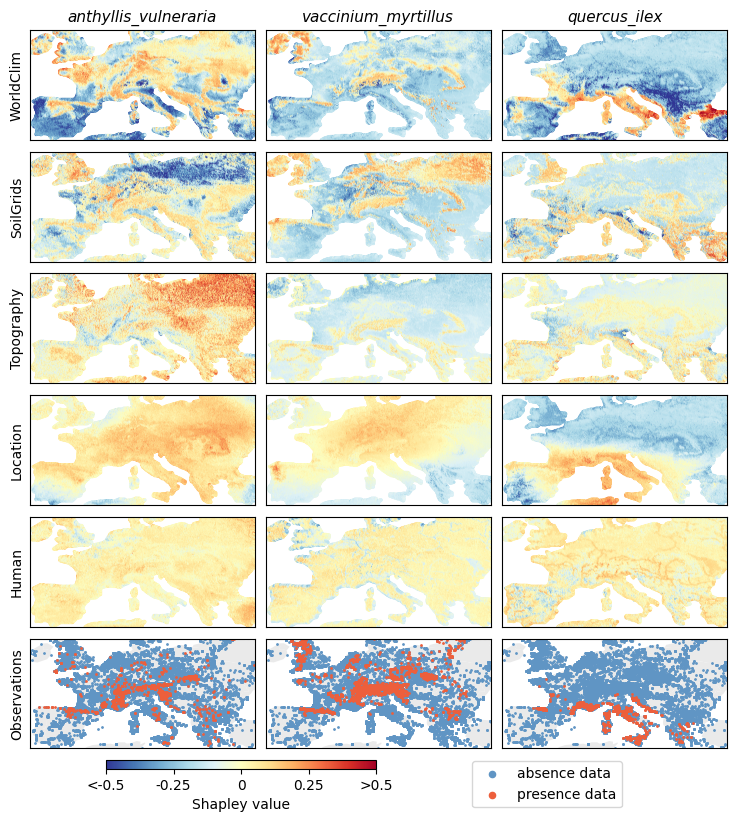

In [8]:
fig, axs = plt.subplots(len(variables_list)+1, 3, figsize=(9, 11))
for j in range(3):
    shapley_values = [shapley_values_1, shapley_values_2, shapley_values_3][j]
    for i, variable in enumerate(variables_list):
        ax = axs[i, j]
        gdf = gpd.GeoDataFrame(shapley_values[:, i], geometry=[Point(lon, lat) for lon, lat in land_points_coordinates])
        gdf.plot(markersize=1, column=0, cmap=cmap, norm=norm, ax=axs[i, j])
        if j == 0:
            axs[i, j].set_ylabel(f"{variable}")
        if i == 0:
            axs[i, j].set_title(species_names[j], style='italic', fontsize=11)        
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == len(variables_list) - 1:
            if j == 0:
                cbar_ax = fig.add_axes([0.210, 0.120, 0.3, 0.008]) # Position: [left, bottom, width, height]
                sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
                cbar.set_label('Shapley value', fontsize=10)
                cbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])
                cbar.set_ticklabels(["<-0.5", "-0.25", "0", "0.25", ">0.5"])
            
    species_obs = data["y"][:, species_indices[j]]
    ax = axs[-1, j]
    world.plot(ax=ax, color=background_color)
    legend = False
    if j == 0:
        ax.set_ylabel("Observations")
    elif j == 1:
        legend = True
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[~species_obs]])
    gdf.plot(ax=ax, color=absence_color, markersize=markersize, label="absence data", legend=legend, alpha=alpha)

    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[species_obs]])
    gdf.plot(ax=ax, color=presence_color , markersize=markersize, label="presence data", legend=legend, alpha=alpha)
        
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if j == 1:
        ax.legend()
        legend = ax.legend(loc='lower center', bbox_to_anchor=(1.25, -0.6), fontsize=10) 
        for handle in legend.legend_handles:
            handle._sizes = [20] # Set the marker size for the legend
    
plt.subplots_adjust(wspace=0.05, hspace=-0.6, bottom=0.05)
plt.savefig("figures/shapley_maps.png", dpi=260, bbox_inches='tight')
plt.show()